In [475]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

karsten_path = "./karsten/answer_sheet_clean.csv"
thiago_path = "./thiago/answer_sheet_clean.csv"
ben_path = "./ben/answer_sheet_clean.csv"

second_mapping_path =  "./mappings/mapping.csv"
first_mapping_path = "./mappings/first_run_mapping.csv"

karsten_answers = pd.read_csv(karsten_path)
thiago_answers = pd.read_csv(thiago_path)
ben_answers = pd.read_csv(ben_path)

first_mapping = pd.read_csv(first_mapping_path)
second_mapping = pd.read_csv(second_mapping_path)

first_mapping = first_mapping.rename(columns={"0": "id"})

### calculate the alignment between ground truth and predicted thickness maps w.r.t. detecting macular thickening

In [476]:
def plot_confusion_matrix(cm, std_cm, save_dir,normalize=True,title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.rcParams.update({'font.size': 32,'figure.figsize':(15,15)})


    plt.figure(figsize=(10,10))

    plt.matshow(np.round(cm,2), cmap=plt.cm.Blues,fignum=1)

    thresh = 0.6
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, 
         "{:0.2f}".format(cm[i, j]) + u"\u00B1"+"{}".format(np.round(std_cm[i,j],2)),
         size="x-small",
         horizontalalignment="center",
         color="black" if cm[i, j] < 0.7 else "white",weight="bold")

    #plt.title(save_dir.split("/")[-1].replace(".png",""))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    print("Saving:",save_dir)
    plt.savefig(save_dir)
    return

In [477]:
def long_to_wide(mapping):
    answers = [[], [], []]
    for name in mapping.record_name.tolist():
        answer = mapping[mapping.record_name == name]

        first = answer["id"].iloc[0]
        second = answer["id"].iloc[1]

        answers[0].append(name)
        answers[1].append(first)
        answers[2].append(second)

    wide_ = pd.DataFrame(answers).T
    wide_ = wide_.rename(columns={0:"record_name", 1:"gt", 2:"p"})
    return wide_

first_mapping_wide = long_to_wide(first_mapping)

In [478]:
#### karstens answers
karsten_abt = pd.merge(first_mapping_wide, karsten_answers,
                       left_on="p", 
                       right_on="id",
                       how="inner")

karsten_abt = pd.merge(karsten_abt,karsten_answers,left_on="gt", right_on="id",how="inner")

# calculate based on abt
karsten_cm = confusion_matrix(karsten_abt["macular edema (0/1)_x"],karsten_abt["macular edema (0/1)_y"])
karsten_cm_norm = karsten_cm / np.sum(karsten_cm,axis=1)[:, np.newaxis]

#### thiagos answers
thiago_abt = pd.merge(first_mapping_wide, thiago_answers,
                       left_on="p", 
                       right_on="id",
                       how="inner")

thiago_abt = pd.merge(thiago_abt,thiago_answers,left_on="gt", right_on="id",how="inner")

# calculate based on abt
thiago_cm = confusion_matrix(thiago_abt["macular edema (0/1)_x"],thiago_abt["macular edema (0/1)_y"])
thiago_cm_norm = thiago_cm / np.sum(thiago_cm,axis=1)[:, np.newaxis]

#### bens answers

ben_abt = pd.merge(second_mapping,ben_answers,left_on="prediction_pseudo", right_on="id",how="inner")
ben_abt = pd.merge(ben_abt,ben_answers,left_on="label_pseudo", right_on="id",how="inner")

# calculate based on abt
ben_cm = confusion_matrix(ben_abt["macular edema (0/1)_x"],ben_abt["macular edema (0/1)_y"])
ben_cm_norm = ben_cm / np.sum(ben_cm,axis=1)[:, np.newaxis]
ben_cm_norm, thiago_cm_norm, karsten_cm_norm

(array([[0.63276836, 0.36723164],
        [0.19047619, 0.80952381]]), array([[0.72906404, 0.27093596],
        [0.17241379, 0.82758621]]), array([[0.72251309, 0.27748691],
        [0.27142857, 0.72857143]]))

#### mean alignment

In [479]:
mean_cm = (karsten_cm_norm + thiago_cm_norm + ben_cm_norm)/3.
std_cm = np.std([karsten_cm_norm , thiago_cm_norm, ben_cm_norm],axis=0)
mean_cm

array([[0.69478183, 0.30521817],
       [0.21143952, 0.78856048]])

Saving: mean_cm.png


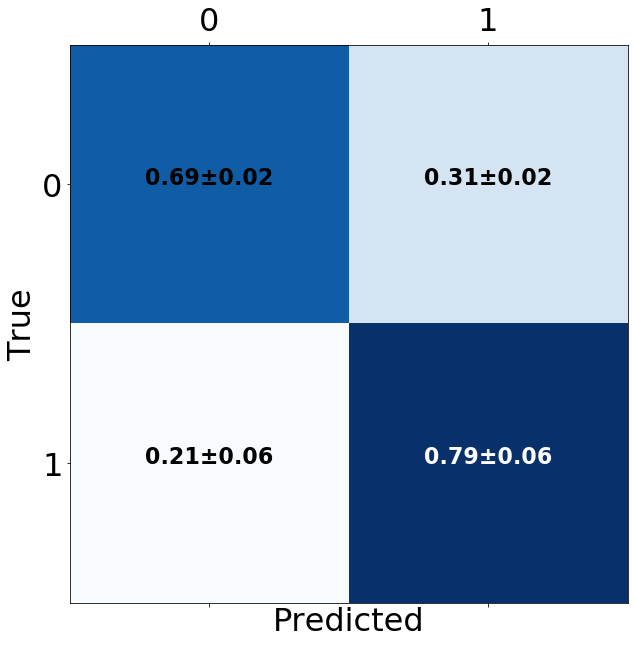

In [480]:
# plot mean alignment
mean_cm = np.array([[0.69, 0.31],
       [0.21, 0.79]])

std_cm = np.array([[0.02, 0.02],
       [0.06, 0.06]])

plot_confusion_matrix(mean_cm, std_cm, save_dir="mean_cm.png")

### calculate alignment ratios between doctors w.r.t. to answers on the very same examples

In [481]:
ka_abt = karsten_abt.rename(columns={"macular edema (0/1)_x": "k_x", "macular edema (0/1)_y": "k_y"})
ka_abt = ka_abt[["record_name", "k_x", "k_y"]]

ta_abt = thiago_abt.rename(columns={"macular edema (0/1)_x": "t_x", "macular edema (0/1)_y": "t_y"})
ta_abt = ta_abt[["record_name", "t_x", "t_y"]]

ba_abt = ben_abt.rename(columns={"macular edema (0/1)_x": "b_x", "macular edema (0/1)_y": "b_y"})
ba_abt = ba_abt[["record_name", "b_x", "b_y"]]

a_abt = pd.merge(ba_abt, ta_abt, left_on="record_name", right_on="record_name", how="inner")
a_abt = pd.merge(ka_abt, a_abt, left_on="record_name", right_on="record_name", how="inner")

a_abt.b_x = a_abt.b_x.astype(int)
a_abt.b_y = a_abt.b_y.astype(int)

In [485]:
def doctor_alignment(ax, ay, bx, by):
    abx = confusion_matrix(ax, bx) / np.sum(confusion_matrix(ax, bx),axis=1)[:, np.newaxis]
    bax = confusion_matrix(bx, ax) / np.sum(confusion_matrix(bx, ax),axis=1)[:, np.newaxis]
    aby = confusion_matrix(ay, by) / np.sum(confusion_matrix(ay, by),axis=1)[:, np.newaxis]
    bay = confusion_matrix(by, ay) / np.sum(confusion_matrix(by, ay),axis=1)[:, np.newaxis]
    
    cm_list = [abx , bax , aby , bay]
        
    alignement_mean = np.mean([abx , bax , aby , bay], axis=0)
    alignement_std = np.std((abx , bax , aby , bay), axis=0, ddof=1)
    
    return alignement_mean, alignement_std, cm_list

In [488]:
np.std(kt_list + kb_list + tb_list, axis=0, ddof=1)

array([[0.07442598, 0.07442598],
       [0.10733179, 0.10733179]])

Saving: inter_doctor_alignment_mean.png


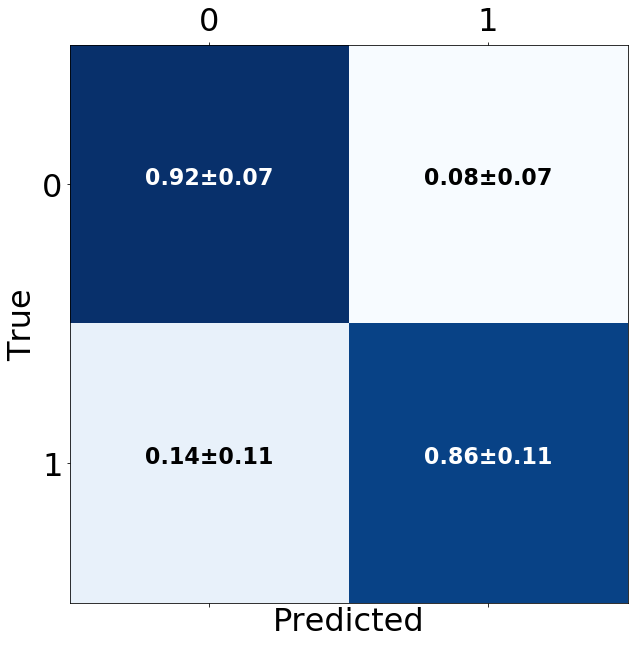

In [490]:
cm_kt , std_cm_kt, kt_list = doctor_alignment(a_abt.k_x, a_abt.k_y, a_abt.t_x, a_abt.t_y)
cm_kb , std_cm_kb, kb_list = doctor_alignment(a_abt.k_x, a_abt.k_y, a_abt.b_x, a_abt.b_y)
cm_tb , std_cm_tb, tb_list = doctor_alignment(a_abt.t_x, a_abt.t_y, a_abt.b_x, a_abt.b_y)


cm = (cm_kt + cm_kb + cm_tb) / 3.
cm_std = np.std(kt_list + kb_list + tb_list, axis=0, ddof=1)

cm, cm_std

plot_confusion_matrix(cm, cm_std, save_dir="inter_doctor_alignment_mean.png")